# Galaxy Zoo

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/Project_GalaxyZoo-galaxypic.png" width=300 align=left></img><br>

## <span style="color:Orange">Overview</span>

Understanding how and why we are here is one of the fundamental questions for the ages. Part of the answer to this question lies in the origins of galaxies, such as our own Milky Way. Yet questions remain about how the Milky Way (or any of the other ~100 billion galaxies in our Universe) was formed and has evolved. Galaxies come in all shapes, sizes and colors: from beautiful spirals to huge ellipticals. “Kevin Schawinski, previously an astrophysicist at Oxford University and co-founder of Galaxy Zoo, described the problem that led to Galaxy Zoo's creation when he was set the task of classifying the morphology of more than 900,000 galaxies by eye that had been imaged by the Sloan Digital Sky Survey at the Apache Point Observatory in New Mexico, USA.”

## <span style="color:Orange">Data Sources</span>

Original Source
* https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data (requires Kaggle account)

File URLs
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_ones_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_zeros_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/central_pixel_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_test_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/training_solutions_rev1.zip

## <span style="color:Orange">Questions</span>

Please refer to the corresponding Project 01 notebook for background questions related to this project. In this project, you are to focused on machine learning application(s).

### <span style="color:LightGreen">Question 01</span>

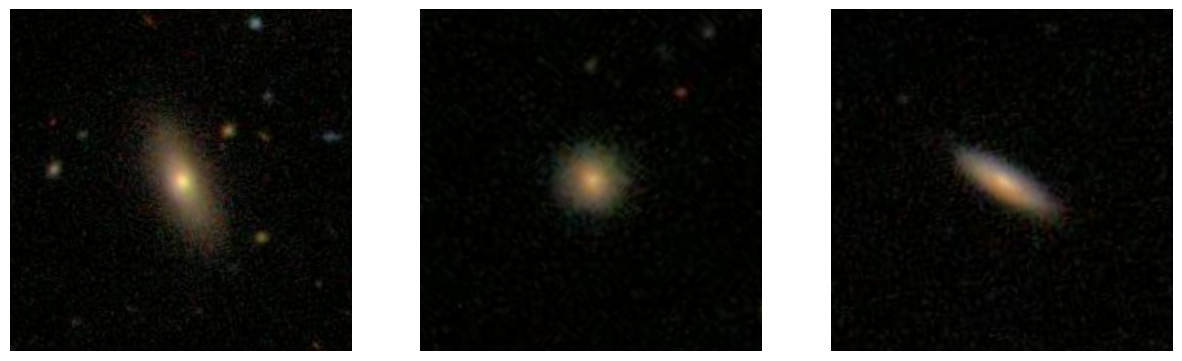

In [ ]:
import requests
import zipfile
from io import BytesIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to download and extract zip files
def download_and_extract(url, extract_to='.'):
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as the_zip:
        the_zip.extractall(path=extract_to)

# Download and extract the dataset
url = 'https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip'
download_and_extract(url, extract_to='./data')

# Path to the extracted images
images_path = './data/images_training_rev1'

# Display a few images
def display_images(images_path, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    image_files = os.listdir(images_path)[:num_images]
    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(images_path, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

display_images(images_path)


In [ ]:
# Download and extract training images and solutions
urls = [
    'https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip',
    'https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/training_solutions_rev1.zip'
]

for url in urls:
    download_and_extract(url, extract_to='./data')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the training solutions and prepare the DataFrame
df = pd.read_csv('./data/training_solutions_rev1.csv')
df.columns = [col.replace('Class', 'Q') for col in df.columns]

# Simplify the problem to binary classification
df['label'] = df.apply(lambda row: 'spiral' if row['Q1.2'] > 0.5 else 'elliptical', axis=1)

# Append '.jpg' to each GalaxyID to form the correct filenames
df['GalaxyID'] = df['GalaxyID'].apply(lambda x: f"{x}.jpg")

# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='./data/images_training_rev1/',
    x_col='GalaxyID',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='./data/images_training_rev1/',
    x_col='GalaxyID',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)


Found 49262 validated image filenames belonging to 2 classes.
Found 12316 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Building the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Adjust based on the size of your dataset
    epochs=10,           # Adjust based on your needs
    validation_data=validation_generator,
    validation_steps=50  # Adjust based on the size of your validation dataset
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

Each Image is labeled with its GalaxyID. Use the benchmark data set as the classification label. Since the training data is the Image, we could use a Convolutional Neural Network (CNN) architecture to build up the training. What is the input data for your Network? Could you design a simple CNN structure for this training?

In [ ]:
import pandas as pd
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the base paths and data directory
base_path = './data'
training_solutions_path = os.path.join(base_path, 'training_solutions_rev1.csv')
training_images_path = os.path.join(base_path, 'images_training_rev1')

# Define the directory to store processed images
data_dir = os.path.join(base_path, 'processed_images')

# Create the dataset
df = pd.read_csv(training_solutions_path)
df.columns = [col.replace('Class', 'Q') for col in df.columns]

# Define galaxy classes
ellipticals = df[(df['Q1.1'] > 0.7) & (df['Q7.1'] > 0.4)]['GalaxyID'].tolist()
spirals = df[(df['Q1.2'] > 0.7) & (df['Q2.1'] > 0.4)]['GalaxyID'].tolist()

# Process images to create training and validation sets
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train', label)
    val_dir = os.path.join(dst, 'validation', label)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    random.shuffle(arr)
    idx = int(len(arr) * percent)
    for i in arr[:idx]:
        shutil.copyfile(os.path.join(src, str(i) + '.jpg'), os.path.join(train_dir, str(i) + '.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i) + '.jpg'), os.path.join(val_dir, str(i) + '.jpg'))

# Adjust the source directory path
src_dir = training_images_path

_proc_images(src_dir, data_dir, 'elliptical', ellipticals, 0.8)
_proc_images(src_dir, data_dir, 'spiral', spirals, 0.8)


In [ ]:
print(ellipticals)

[891265, 636808, 843880, 689468, 337161, 226669, 278015, 266606, 198490, 997296, 501162, 177939, 913628, 614616, 931868, 456651, 913657, 626804, 257376, 576680, 275437, 103902, 993399, 762682, 361749, 221786, 384593, 601080, 253468, 875641, 184775, 619149, 107461, 855784, 777623, 260961, 670924, 229403, 796153, 989050, 564459, 377483, 103645, 955392, 591238, 797642, 143307, 188405, 364944, 581391, 536585, 562171, 938533, 226728, 604860, 878194, 856733, 161178, 992185, 560124, 920717, 500275, 826218, 604039, 367712, 972309, 234835, 614221, 715690, 159483, 306583, 157484, 330274, 559650, 340504, 187524, 183817, 490176, 654351, 323787, 591675, 396238, 863441, 467898, 180707, 164494, 629698, 901413, 155994, 607797, 919385, 716287, 227917, 384970, 380552, 781046, 786236, 808321, 797502, 512091, 604516, 215163, 359485, 335537, 951880, 178583, 319879, 138164, 905029, 434306, 985891, 292593, 451020, 215919, 368840, 908829, 729642, 255469, 487990, 246741, 594191, 156791, 668685, 889574, 359600,

Image for sprial galaxy in training dataset


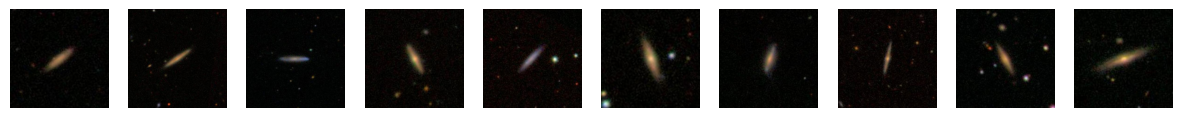

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_elliptical_images(data_dir, num_images=10):
    elliptical_dir = os.path.join(data_dir, 'train', 'spiral')  # Adjust as necessary

    # Check if the directory exists
    if not os.path.isdir(elliptical_dir):
        print("Directory not found:", elliptical_dir)
        return

    # Get a list of image filenames
    image_files = os.listdir(elliptical_dir)[:num_images]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(elliptical_dir, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display elliptical galaxy images
display_elliptical_images(data_dir)


Image for eliptical galaxy in training dataset


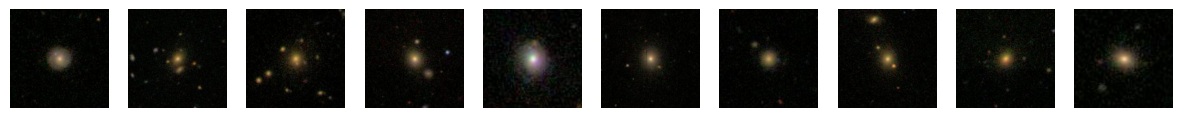

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_elliptical_images(data_dir, num_images=10):
    elliptical_dir = os.path.join(data_dir, 'train', 'elliptical')  # Adjust as necessary

    # Check if the directory exists
    if not os.path.isdir(elliptical_dir):
        print("Directory not found:", elliptical_dir)
        return

    # Get a list of image filenames
    image_files = os.listdir(elliptical_dir)[:num_images]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(elliptical_dir, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display elliptical galaxy images
display_elliptical_images(data_dir)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)


Found 9556 images belonging to 2 classes.
Found 2390 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rest of your script...
# Data augmentation setup, data generators, etc.

# Net architecture
model = tf.keras.models.Sequential([
    # first convolution layer, input is an 180x180 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile and train the model as per your setup


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 128)      

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 5  # You can change this number based on your needs
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/10
103/299 [=========>....................] - ETA: 6:54 - loss: 0.0471 - accuracy: 0.9839

KeyboardInterrupt: ignored

75/75 [==============================] - 45s 602ms/step - loss: 0.0420 - accuracy: 0.9866
Validation Loss: 0.04201813414692879
Validation Accuracy: 0.9866108894348145


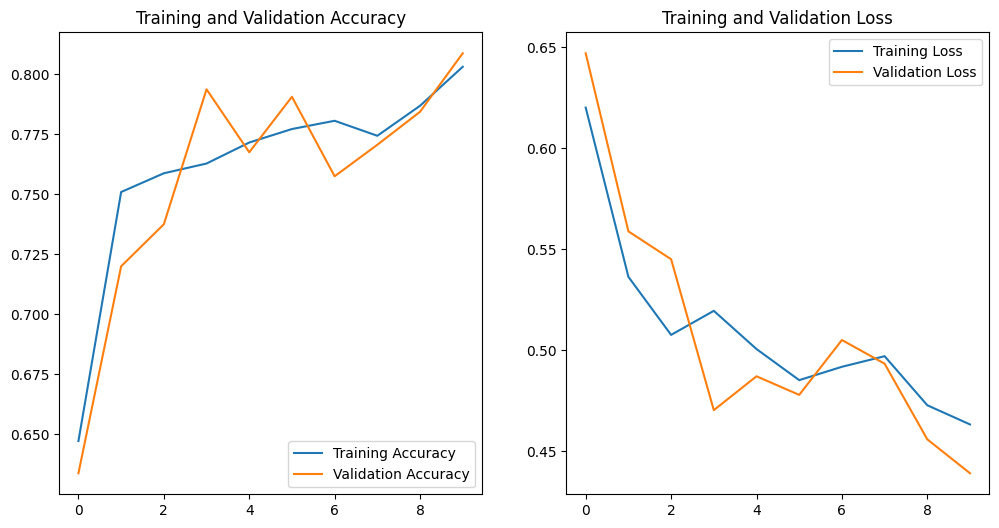

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Test:

1/1 [==============================] - 0s 84ms/step


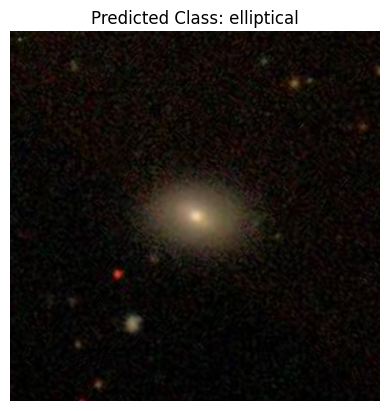

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras.preprocessing import image

# Load the DataFrame
df = pd.read_csv('./data/training_solutions_rev1.csv')
df['GalaxyID'] = df['GalaxyID'].apply(lambda x: f"{x}.jpg")

# Function to display a random galaxy image and predict its class
def display_and_predict_random_galaxy(data_dir, model):
    # Select a random GalaxyID from the DataFrame
    random_image_name = random.choice(df['GalaxyID'].tolist())
    image_path = os.path.join(data_dir, 'images_training_rev1', random_image_name)

    # Check if the image file exists
    if not os.path.isfile(image_path):
        print("Image file not found:", image_path)
        return

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the galaxy
    predictions = model.predict(img_array)
    class_names = ['elliptical', 'spiral']
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(mpimg.imread(image_path))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage
data_dir = './data'  # Adjust this if necessary
# model = ...  # Make sure to load your trained model here
display_and_predict_random_galaxy(data_dir, model)


1/1 [==============================] - 0s 80ms/step


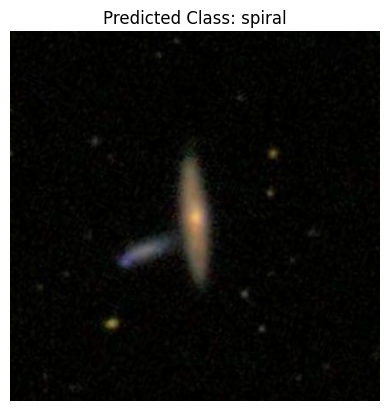

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Function to load, preprocess, and predict the class of a specific galaxy image
def load_predict_display_galaxy(image_id, data_dir, model):
    image_path = os.path.join(data_dir, 'images_training_rev1', f'{image_id}.jpg')

    # Check if the image file exists
    if not os.path.isfile(image_path):
        print("Image file not found:", image_path)
        return

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class of the galaxy
    predictions = model.predict(img_array)
    class_names = ['elliptical', 'spiral']
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(mpimg.imread(image_path))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage
data_dir = './data'  # Adjust this if necessary
image_id = '100143'  # The specific image ID to predict
load_predict_display_galaxy(image_id, data_dir, model)  # Replace 'model' with your actual trained model


Input image which is not from dataset

1/1 [==============================] - 0s 183ms/step


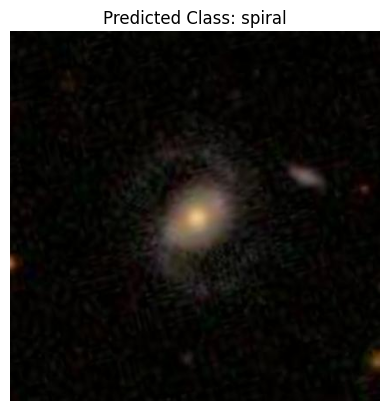

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming 'model' is your trained model

# Path to the image
image_id = '100813'
image_path = os.path.join(base_path, 'images_training_rev1', f'{image_id}.jpg')

# Load and preprocess the image
img = image.load_img(image_path, target_size=(180, 180))  # Adjust target_size as per your model's input size
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict the class of the image
predictions = model.predict(img_array)
class_names = ['elliptical', 'spiral']  # Adjust according to your classes
predicted_class = class_names[np.argmax(predictions)]

# Display the image and prediction
plt.imshow(mpimg.imread(image_path))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


Correctly predicted! even the spiral is quite blurry to realized.

---

## <span style="color:Orange">References</span>

__[<span style="color:Red">1</span>]__ K.W. Willet, _et.al_, "Galaxy Zoo 2: detailed morphological classifications for 304,122 galaxies from the Sloan Digital Sky Survey", _Mon.Not.Roy.Astron.Soc_. 435 (2013) 2835, e-Print: [1308.3496](https://arxiv.org/abs/1308.3496) [astro-ph.CO]


---

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer
* Final version: Neng Ji

© Copyright 2023